# Cleaned Code

In [63]:
import sys

In [64]:
#!{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install sqlalchemy
# !{sys.executable} -m pip install psycopg2
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install seaborn

## Imports

In [187]:
import pandas as pd
import random
import numpy as np
import datetime
import sys
import math
import seaborn as sb

from sqlalchemy import create_engine, text, Column, Integer, Float, DateTime, String
from sqlalchemy.orm import sessionmaker, declarative_base
import psycopg2 as pg

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import absolute, asarray
import xgboost as xgb
from xgboost import XGBRegressor

.

## All Selects

In [145]:
engine = create_engine('postgresql://pg-datacenter:Dua2h,i,JY>,,8)U<)aLIguz@pg-datacenter-primary.atos-development.svc:5432/pg-datacenter')

In [147]:
products_df = pd.DataFrame(engine.connect().execute(text('select * from products;')), columns = ['id', 'manufacturer', 'name', 'code', 'colors', 'price', 'tax_rate'])
shops_df = pd.DataFrame(engine.connect().execute(text('select * from shops;')), columns = ['id', 'city', 'postcode', 'street_1', 'street_2', 'iot_certificate'])
pos_devices_df = pd.DataFrame(engine.connect().execute(text('select * from pos_devices;')), columns = ['id', 'shop_id', 'serial', 'iot_certificate'])
employees_df = pd.DataFrame(engine.connect().execute(text('select * from employees;')), columns = ['id', 'primary_shop_id', 'name', 'card_id'])
customers_df = pd.DataFrame(engine.connect().execute(text('select * from customers;')), columns = ['id', 'name', 'card_id', 'street_1', 'street_2', 'postcode', 'city', 'discount'])
receipts_df = pd.DataFrame(engine.connect().execute(text('select * from receipts;')), columns = ['id', 'shop_id', 'pos_device_id', 'customer_id', 'created_at',
                                                                                                 'discount_total', 'tax_total', 'amount_total', 'employee_id','delivery_shop_id'])
receipt_positions_df = pd.DataFrame(engine.connect().execute(text('select * from receipt_positions;')), columns = ['id', 'receipt_id', 'position', 'product_id', 'size', 'color',
                                                                                                                   'quantity', 'price', 'discount', 'discount_reason', 'tax_rate'])
weekly_forecast_df = pd.DataFrame(engine.connect().execute(text('select * from weekly_forecast;')))
daily_forecast_df = pd.DataFrame(engine.connect().execute(text('select * from daily_forecast;')))

Exception during reset or similar
Traceback (most recent call last):
  File "/opt/app-root/lib64/python3.8/site-packages/sqlalchemy/pool/base.py", line 991, in _finalize_fairy
    fairy._reset(
  File "/opt/app-root/lib64/python3.8/site-packages/sqlalchemy/pool/base.py", line 1440, in _reset
    pool._dialect.do_rollback(self)
  File "/opt/app-root/lib64/python3.8/site-packages/sqlalchemy/engine/default.py", line 657, in do_rollback
    dbapi_connection.rollback()
psycopg2.errors.AdminShutdown: terminating connection due to administrator command
SSL connection has been closed unexpectedly

Exception during reset or similar
Traceback (most recent call last):
  File "/opt/app-root/lib64/python3.8/site-packages/sqlalchemy/pool/base.py", line 991, in _finalize_fairy
    fairy._reset(
  File "/opt/app-root/lib64/python3.8/site-packages/sqlalchemy/pool/base.py", line 1440, in _reset
    pool._dialect.do_rollback(self)
  File "/opt/app-root/lib64/python3.8/site-packages/sqlalchemy/engine/defa

.

## Create Receipt_DF with quantity join of quantity column

In [151]:
def create_quantity_list():
    all_receipt_ids = list(receipts_df.id.values)
    quantities = []
    
    for rec_id in all_receipt_ids:
        cur_df = receipt_positions_df[receipt_positions_df["receipt_id"]==rec_id]
        sold_amount = sum(list(cur_df.quantity.values))
        quantities.append(sold_amount)
    
    return quantities

In [152]:
with_quantity_df = receipts_df
with_quantity_df["quantities"] = create_quantity_list

.

## Create DF that joins receipts and receipt_positions and reduces to relevant columns

In [153]:
relevant_receipt_cols = receipts_df[["id", "created_at", "customer_id", "employee_id", "shop_id"]]

In [154]:
merged_df = pd.merge(receipt_positions_df, relevant_receipt_cols, left_on='receipt_id', right_on='id')

In [155]:
all_data_df = merged_df.drop(columns = ["id_x", "id_y", "position", "tax_rate", "receipt_id"])

.

## Create different date features from the Timestamp

In [156]:
def date_features(pdf):
    df = pdf
    # Date Features
    df['date'] = pd.to_datetime(df['created_at'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.isocalendar().day
    df['weekofyear'] = df.date.dt.isocalendar().week
    df['hourofday'] = df.date.dt.hour
    
    # Additionnal Data Features
    df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))
    
    # Drop date
    df.drop('date', axis=1, inplace=True)
    
    return df

In [157]:
with_date_features_df = date_features(all_data_df)

.

## Check Relevance of each feature

<AxesSubplot:>

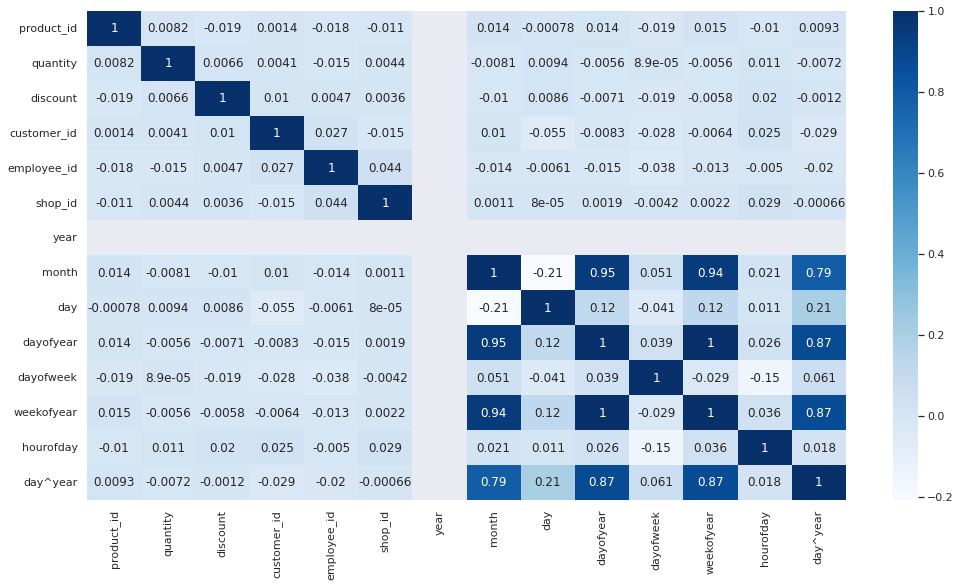

In [158]:
sb.set(rc={'figure.figsize':(17,9)})
corr = with_date_features_df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

.

## Remove irrelevant features

#### These features would usually be very relevant. But because this data is generated randomly there are no underlying patterns between different customers, shops or product categories

In [159]:
relevant_df = with_date_features_df.drop(columns = ["size", "color", "discount", "discount_reason", "customer_id", "employee_id", "shop_id"])

.

## Creating more different datetime feature that could improve the model

In [160]:
relevant_df['hourly_avg']  = relevant_df.groupby(['product_id','hourofday'])['quantity'].transform('mean')
relevant_df['daily_avg']  = relevant_df.groupby(['product_id','dayofweek'])['quantity'].transform('mean')
relevant_df['monthly_avg'] = relevant_df.groupby(['product_id','month'])['quantity'].transform('mean')

In [161]:
relevant_df['hourly_sum']  = relevant_df.groupby(['product_id','hourofday'])['quantity'].transform('sum') # wie oft wurde das Produkt insgesamt in der jeweiligen Stunde gekauft
relevant_df['daily_sum']  = relevant_df.groupby(['product_id','dayofweek'])['quantity'].transform('sum')
relevant_df['monthly_sum'] = relevant_df.groupby(['product_id','month'])['quantity'].transform('sum')

#### All Sales of product_id=1 in the 11th hourofday

#### This shows bias of avg_values --> Hourly Average of 1,6 implies that the product 1 will be bought 1,6 every single day in the 11th hour. But this is wrong as there are many days where product 1 was not bought in the 11th hour, but these do not occurr in the data which causes this bias. Because of this, these avg and sum features are omitted.

In [162]:
relevant_df.groupby(['product_id']).get_group(1).groupby(['hourofday']).get_group(11)

,product_id,quantity,price,created_at,year,month,day,dayofyear,dayofweek,weekofyear,hourofday,day^year,hourly_avg,daily_avg,monthly_avg,hourly_sum,daily_sum,monthly_sum
210,1,2,199.98,2023-01-10 11:07:02,2023,1,10,10,2,2,11,20.115602,1.666667,1.444444,1.352941,5,13,23
6085,1,2,199.98,2023-01-27 11:14:16,2023,1,27,27,5,4,11,27.683584,1.666667,1.600000,1.352941,5,16,23
8043,1,1,99.99,2023-04-05 11:52:32,2023,4,5,95,3,14,11,34.920342,1.666667,1.000000,1.000000,5,4,4


.

## Remove redundant date features (redundant according to correlation)

In [163]:
cleaned_relevant_df = relevant_df.drop(["month","dayofyear","weekofyear", "day^year", "created_at"], axis=1)

# Create realistic Test Data

#### forecast one week from Monday to Saturday

In [164]:
day_1 = pd.to_datetime("2023-04-10")
day_2 = pd.to_datetime("2023-04-11")
day_3 = pd.to_datetime("2023-04-12")
day_4 = pd.to_datetime("2023-04-13")
day_5 = pd.to_datetime("2023-04-14")
day_6 = pd.to_datetime("2023-04-15")

In [165]:
prediction_days = [day_1, day_2, day_3, day_4, day_5, day_6]

In [166]:
date_values = []

for date in prediction_days:
    month = date.month
    day = date.day
    dayofweek = date.dayofweek + 1
    
    date_values.append([month, day, dayofweek])

In [167]:
row_values = []

for prod_id in list(products_df.id.values):
    for col in date_values:
        row_values.append([prod_id, col[0], col[1], col[2]])

In [168]:
test_data = pd.DataFrame(row_values, columns = ["product_id", "month", "day", "dayofweek"])
test_data

,product_id,month,day,dayofweek
0,1,4,10,1
1,1,4,11,2
2,1,4,12,3
3,1,4,13,4
4,1,4,14,5
...,...,...,...,...
1033,173,4,11,2
1034,173,4,12,3
1035,173,4,13,4
1036,173,4,14,5


.

## Create Train Data in the format of the given test data

In [172]:
train_data = relevant_df.drop(columns = ["price","created_at","year","dayofyear","weekofyear","hourofday","day^year"])

In [173]:
label = list(train_data.quantity.values)

In [257]:
train_data

,product_id,quantity,month,day,dayofweek,hourly_avg,daily_avg,monthly_avg,hourly_sum,daily_sum,monthly_sum
0,153,1,2,25,6,1.714286,1.277778,1.818182,12,23,20
1,44,2,2,25,6,1.571429,1.800000,1.437500,11,27,23
2,66,3,1,11,3,1.571429,1.857143,1.318182,11,13,29
3,17,2,1,11,3,1.600000,3.500000,1.705882,16,7,29
4,132,2,1,11,3,1.400000,1.454545,1.411765,7,16,24
...,...,...,...,...,...,...,...,...,...,...,...
9995,72,5,1,3,2,1.800000,1.700000,1.695652,27,17,39
9996,81,1,1,3,2,1.500000,1.142857,1.592593,15,8,43
9997,172,1,2,11,6,1.857143,1.500000,1.541667,26,27,37
9998,140,1,2,11,6,1.500000,1.333333,1.421053,18,24,27


## Configuring the model

In [175]:
model = XGBRegressor(n_estimators=1000, max_depth=6, eta=0.1, subsample=0.7, colsample_bytree=0.8)

#### As explained omitting the newly generated avg and sum Spalten

In [176]:
X, y = train_data.values[:,[0,2,3,4]], train_data.values[:,1]

In [177]:
X

array([[153, 2, 25, 6],
       [44, 2, 25, 6],
       [66, 1, 11, 3],
       ...,
       [172, 2, 11, 6],
       [140, 2, 11, 6],
       [168, 2, 11, 6]], dtype=object)

In [178]:
y

array([1, 2, 3, ..., 1, 1, 1], dtype=object)

## Cross Validation for general MAE Performance

In [179]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [180]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.704 (0.020)


## Training the model for test data prediction

In [181]:
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [182]:
predictions = model.predict(test_data.values)

In [183]:
rounded_predictions = []
for value in predictions:
    rounded_predictions.append(round(value,2))

In [184]:
test_data["predicted_amount"] = rounded_predictions

## Displaying the predictions per product per day

In [185]:
test_data["year"] = [2023 for x in range(len(test_data))]
test_data["id"] = test_data.index
test_data

,product_id,month,day,dayofweek,predicted_amount,year,id
0,1,4,10,1,2.62,2023,0
1,1,4,11,2,1.25,2023,1
2,1,4,12,3,1.09,2023,2
3,1,4,13,4,0.99,2023,3
4,1,4,14,5,0.95,2023,4
...,...,...,...,...,...,...,...
1033,173,4,11,2,2.75,2023,1033
1034,173,4,12,3,2.63,2023,1034
1035,173,4,13,4,1.44,2023,1035
1036,173,4,14,5,1.45,2023,1036


## Creating datetime column for Visualization in Grafana

In [190]:
timestamps = []
for i, row in test_data.iterrows():
    c_year = int(row['year'])
    c_month = int(row['month'])
    c_day = int(row['day'])
    curr_stamp = pd.to_datetime(f'{c_year}-{c_month}-{c_day}')
    timestamps.append(curr_stamp)

In [191]:
test_data_with_timestamp = test_data

In [192]:
test_data_with_timestamp["date"] = timestamps

In [193]:
test_data_with_timestamp

,product_id,month,day,dayofweek,predicted_amount,year,id,date
0,1,4,10,1,2.62,2023,0,2023-04-10
1,1,4,11,2,1.25,2023,1,2023-04-11
2,1,4,12,3,1.09,2023,2,2023-04-12
3,1,4,13,4,0.99,2023,3,2023-04-13
4,1,4,14,5,0.95,2023,4,2023-04-14
...,...,...,...,...,...,...,...,...
1033,173,4,11,2,2.75,2023,1033,2023-04-11
1034,173,4,12,3,2.63,2023,1034,2023-04-12
1035,173,4,13,4,1.44,2023,1035,2023-04-13
1036,173,4,14,5,1.45,2023,1036,2023-04-14


## Insert daily sales forecast into the database

In [200]:
Base = declarative_base()

Session = sessionmaker(bind=engine)
session = Session()

In [201]:
class Daily_Forecast(Base):
    __tablename__ = 'daily_forecast'
    
    id = Column(Integer, primary_key=True)
    product_id = Column(Integer)
    date = Column(DateTime)
    year = Column(Integer)
    month = Column(Integer)
    day = Column(Integer)
    day_of_week = Column(Integer)
    predicted_quantity = Column(Float)

In [202]:
daily_forecast_rows = []
for i, row in test_data_with_timestamp.iterrows():
    current_insert = Daily_Forecast(id=row["id"], product_id=row["product_id"], date=row["date"], year=row["year"], month=row["month"], day=row["day"], day_of_week=row["dayofweek"], predicted_quantity=row["predicted_amount"])
    daily_forecast_rows.append(current_insert)

In [203]:
session.add_all(daily_forecast_rows[0:250])
session.commit()

In [205]:
session.add_all(daily_forecast_rows[250:500])
session.commit()

In [206]:
session.add_all(daily_forecast_rows[500:750])
session.commit()

In [207]:
session.add_all(daily_forecast_rows[750:len(daily_forecast_rows)])
session.commit()

In [209]:
session.rollback()
session.close()

In [208]:
pd.DataFrame(engine.connect().execute(text('select * from daily_forecast;')), columns = ["id", "product_id", "date", "year", "month", "day", "day_of_week", "predicted_quantity"])

,id,product_id,date,year,month,day,day_of_week,predicted_quantity
0,0,1,2023-04-10,2023,4,10,1,2.62
1,1,1,2023-04-11,2023,4,11,2,1.25
2,2,1,2023-04-12,2023,4,12,3,1.09
3,3,1,2023-04-13,2023,4,13,4,0.99
4,4,1,2023-04-14,2023,4,14,5,0.95
...,...,...,...,...,...,...,...,...
1033,1033,173,2023-04-11,2023,4,11,2,2.75
1034,1034,173,2023-04-12,2023,4,12,3,2.63
1035,1035,173,2023-04-13,2023,4,13,4,1.44
1036,1036,173,2023-04-14,2023,4,14,5,1.45


## Insert weekly forecast into the database

In [243]:
Base = declarative_base()

Session = sessionmaker(bind=engine)
session = Session()

In [244]:
class Weekly_Forecast(Base):
    __tablename__ = 'weekly_forecast'
    
    id = Column(Integer, primary_key=True)
    product_id = Column(Integer)
    product_price = Column(Float)
    product_category = Column(String)
    product_id_str = Column(String)
    predicted_quantity = Column(Float)

In [245]:
weekly_prediction = test_data.groupby(['product_id'])['predicted_amount'].sum().reset_index()

In [246]:
weekly_prediction["id"] = weekly_prediction.index
weekly_prediction

,product_id,predicted_amount,id
0,1,7.73,0
1,2,6.02,1
2,3,10.68,2
3,4,12.74,3
4,5,11.42,4
...,...,...,...
168,169,10.78,168
169,170,13.11,169
170,171,16.01,170
171,172,14.88,171


## Adding additional columns for Grafana visualization

In [247]:
categories = []
prices = []
manufacturers = []
for i, row in weekly_prediction.iterrows():
    current_id = row["product_id"]
    current_df = products_df[products_df["id"]==current_id]
    current_price = current_df.price.values[0]
    current_cat = current_df.name.values[0]
    current_man = current_df.manufacturer.values[0]
    
    prices.append(current_price)
    categories.append(current_cat)
    manufacturers.append(current_man)

In [248]:
weekly_prediction["price"] = prices

In [249]:
weekly_prediction["category"] = categories

In [250]:
weekly_prediction["manufacturer"] = manufacturers

In [251]:
weekly_prediction

,product_id,predicted_amount,id,price,category,manufacturer
0,1,7.73,0,99.99,Sneaker,Nike
1,2,6.02,1,19.99,T-Shirt,Adidas
2,3,10.68,2,49.99,Long pants,Puma
3,4,12.74,3,199.99,Winter jacket,The North Face
4,5,11.42,4,39.99,Short pants,Levis
...,...,...,...,...,...,...
168,169,10.78,168,99.99,Long pants,Nike
169,170,13.11,169,69.99,Dress,Zara
170,171,16.01,170,129.99,Summer jacket,Levis
171,172,14.88,171,109.99,Sneaker,Adidas


## Insert the data

In [252]:
weekly_forecast_rows = []
for i, row in weekly_prediction.iterrows():
    current_insert = Weekly_Forecast(id=row["id"], product_id=row["product_id"], product_price=row["price"], product_category=row["category"], product_id_str=row["manufacturer"], predicted_quantity=row["predicted_amount"])
    weekly_forecast_rows.append(current_insert)

In [253]:
session.add_all(weekly_forecast_rows)
session.commit()

In [254]:
session.rollback()
session.close()

In [256]:
pd.DataFrame(engine.connect().execute(text('select * from weekly_forecast;')), columns = ["id", "product_id", "price", "category", "manufacturer", "predicted_quantity"])

,id,product_id,price,category,manufacturer,predicted_quantity
0,0,1,99.99,Sneaker,Nike,7.73
1,1,2,19.99,T-Shirt,Adidas,6.02
2,2,3,49.99,Long pants,Puma,10.68
3,3,4,199.99,Winter jacket,The North Face,12.74
4,4,5,39.99,Short pants,Levis,11.42
...,...,...,...,...,...,...
168,168,169,99.99,Long pants,Nike,10.78
169,169,170,69.99,Dress,Zara,13.11
170,170,171,129.99,Summer jacket,Levis,16.01
171,171,172,109.99,Sneaker,Adidas,14.88
